#Project Overview

Supply Path Optimization (SPO) refers to the traffic management process that optimizes interactions between supply and demand. As a leading SSP in the industry, RISE leverages Data Science solutions to streamline the SPO process and maintain optimal pathways while considering the traffic limitations and KPIs of our demand partners.

During the integration process with the Rise Marketplace, our Demand Partners (Buyers) set a QPS (queries per second) limit, which defines the number of requests Rise can route through the SPO pipeline. This QPS constraint ensures that the SSP (Rise) does not overload the demand servers and directs only relevant traffic through the system.

Recently, our demand partners have raised concerns about a decline in performance attributed to "low-value" traffic. "Low-value" traffic is characterized by a low probability of receiving any response from buyers.

For example,  when RISE sends a request to Buyer B, this buyer may not respond to the auction opportunity (as illustrated in the flow chart below). While there may be various reasons for a lack of response, in this context, we define a "no-bid" as an indication that the buyer is uninterested.

As a potential Data Scientist at RISE, you are tasked with evaluating these assumptions and offer an ML solution that meets the business needs.

The auction Flow:

* https://www.publift.com/adteach/what-is-programmatic-advertising
* https://pubmatic.com/blog/supply-path-optimization-tips/
* https://risecodes.com/blog/


Exercise Structure
* **SQL** - Write clean, executable SQL code to accomplish the tasks specified in this section. In case the code is not running or you didn't finish the task, please provide a detailed explanation and theoretical solution.
* **Modeling** - Design and implement the entire ML solution, including a detailed EDA, the definition of the relevant monitoring tools and final conclusions. **Add text cells explaining your thinking, findings and results.**
In the case your code is not running or you didn't finish the task, please provide a detailed explanation and a pseudo code / theoretical solution.

##INSTALLS

In [253]:
#basic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for sql part
import sqlite3
pd.set_option('display.float_format', '{:.2f}'.format)


##IMPORT DATA

In [254]:
path ='spo_dataset_sample.csv'
df = pd.read_csv(path)

* 'timestamp' - dd/mm/yyyy hh:mm:ss
* 'org' - organization id
* 'domain' - traffic source
* 'country' - country
* 'adtype' - banner/video
* 'os' - device operation system
* 'device_type' - Mobile/PC/Tablet
* 'Cookie_Sync - Cookie integration between supply & demand binary field Success/Failure [1,0]
* 'IncomingFloor_grp' -The floor the publisher defines via request params (in dollar units)
* 'advertiserid' - demand/buyer identifier
* 'requests' - requests/offers sent to the demand (requests=bids+errors)
* 'bids' - amount of incoming bids recieved from the deamnd
* 'errors' - no bid+invalid request
* 'wins' - win in internal auction
* 'impressions' - ad impression (after extrenal auction win)
* 'rev' - revenue (in dollar units)


Metrics:
* bid rate =bid/requests
* win rate = wins/bids
* success rate = impressions/wins
* fill Rate = impressions/requests
* revenue per request = revenue/request
* CPM = 1000*(revenue/impressions)

#SQL

 1. Identify the top N demand partners that collectively contribute to 80% of total revenue.
 2. Filter the data based on the demand partners list from point 1.
 3. Identify the top N supply partners that collectively holds 80% of the revenue.
 4. Identify the top N supply partners that collectively holds 80% of the requests.
 5. For each device type, calculate avg cpm,bid rate,success rate,win rate and RR (revenue per request).
 6. Calculate the same metrics from point 5 for each domain & device type combination.
 7. For each buyer and cookie_sync combination, calculate the RR and then divide the RR by the total buyer RR.
 8. For each buyer & day & hour combination, extract the top 3 performing orgs in terms of RR.

In [255]:
###Create SQL databae
conn = sqlite3.connect('rise_programmatic.db')
df.to_sql('spo_daily', conn, if_exists='replace', index=False)

475933

In [220]:
# 1

In [224]:
query = '''WITH RevenueContribution AS (
    SELECT
        advertiserid,
        SUM(rev) AS total_revenue,
        SUM(rev) / (SELECT SUM(rev) FROM spo_daily) AS revenue_percentage
    FROM spo_daily
    GROUP BY advertiserid
),
CumulativeRevenue AS (
    SELECT
        advertiserid,
        total_revenue,
        revenue_percentage,
        ROUND(SUM(revenue_percentage) OVER (ORDER BY total_revenue DESC), 1) AS cumulative_percentage
    FROM RevenueContribution
)
SELECT
    advertiserid,
    total_revenue,
    cumulative_percentage
FROM CumulativeRevenue
WHERE cumulative_percentage <= 0.8
ORDER BY cumulative_percentage ASC;
'''

df_result_1 = pd.read_sql_query(query, conn)

# Display the results
df_result_1

,advertiserid,total_revenue,cumulative_percentage
0,pubmatic-new,129626.22,0.30
1,sharethrough,86583.53,0.50
2,xandr,77569.39,0.70
3,magnite,71021.31,0.80


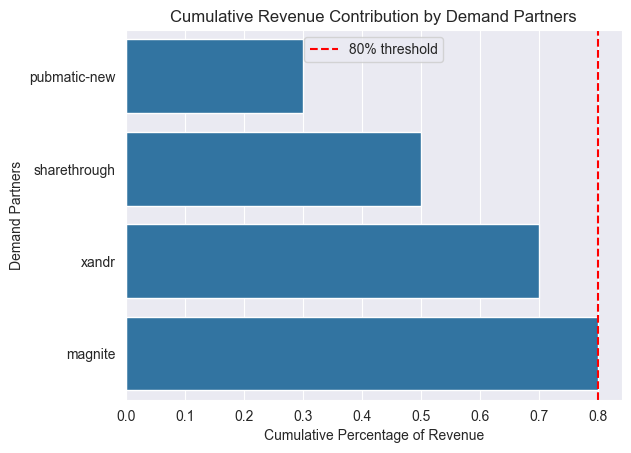

In [225]:
sns.barplot(data=df_result_1, x='cumulative_percentage', y='advertiserid', orient='h')
plt.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
plt.title('Cumulative Revenue Contribution by Demand Partners')
plt.xlabel('Cumulative Percentage of Revenue')
plt.ylabel('Demand Partners')
plt.legend()
plt.show()

In [217]:
# 2

In [226]:
cursor = conn.cursor()
delete_query = """
DELETE FROM spo_daily
WHERE advertiserid NOT IN ('pubmatic-new', 'sharethrough', 'xandr', 'magnite');
"""
cursor.execute(delete_query)
conn.commit()

In [227]:
# 3

In [228]:
query = '''
WITH RevenueContribution AS (
    SELECT
        supply_org,
        SUM(rev) AS total_revenue,
        SUM(rev) * 1.0/ (SELECT SUM(rev) FROM spo_daily) AS revenue_percentage
    FROM spo_daily
    GROUP BY supply_org
),
CumulativeRevenue AS (
    SELECT
        supply_org,
        total_revenue,
        ROUND(SUM(revenue_percentage) OVER (ORDER BY total_revenue DESC), 3) AS cumulative_percentage
    FROM RevenueContribution
),
Threshold AS (
    SELECT
        MIN(cumulative_percentage) AS next_threshold
    FROM CumulativeRevenue
    WHERE cumulative_percentage > 0.8
)
SELECT
    supply_org,
    total_revenue,
    cumulative_percentage
FROM CumulativeRevenue
WHERE cumulative_percentage <= (SELECT next_threshold FROM Threshold)
ORDER BY cumulative_percentage ASC;

'''

df_result_3 = pd.read_sql_query(query, conn)

# Display the results
df_result_3

,supply_org,total_revenue,cumulative_percentage
0,6270d6bc899612000122cdcf,27366.01,0.07
1,62b9c03d19862c0001540bb8,26315.99,0.15
2,602a3862c8b2f90001b1bdab,25514.48,0.22
3,6280c6f1899612000123320b,18372.65,0.27
4,63832beef8189a00015cb6d3,16048.18,0.31
5,5f7987afc9042200018d3351,14914.36,0.35
6,621385c92fc5d1000186feed,13377.62,0.39
7,60cb471cc019140001958db4,11580.60,0.42
8,5e415a71acebdc000190e321,10057.37,0.45
9,623adae8efc76b0001f0ff79,9926.57,0.48


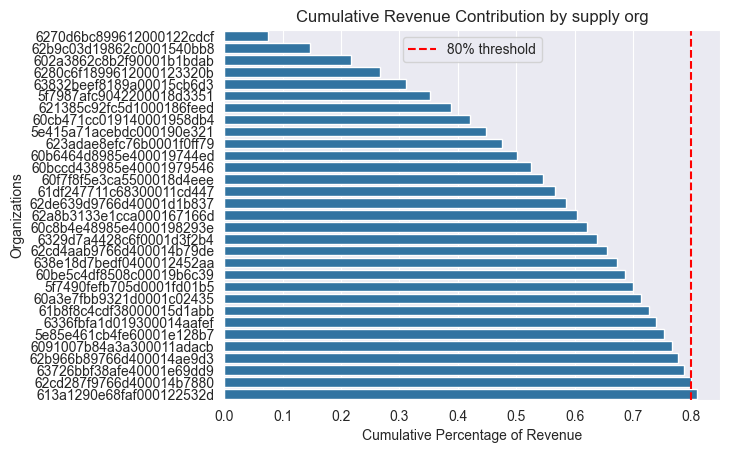

In [229]:
sns.barplot(data=df_result_3, x='cumulative_percentage', y='supply_org', orient='h')
plt.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
plt.title('Cumulative Revenue Contribution by supply org')
plt.xlabel('Cumulative Percentage of Revenue')
plt.ylabel('Organizations')
plt.legend()
plt.show()

In [230]:
# 4

In [231]:
query = '''
WITH RequestContribution AS (
    SELECT
        supply_org,
        SUM(requests) AS total_requests,
        SUM(requests) * 1.0 / (SELECT SUM(requests) FROM spo_daily) AS request_percentage
    FROM spo_daily
    GROUP BY supply_org
),
CumulativeRequests AS (
    SELECT
        supply_org,
        total_requests,
        ROUND(SUM(request_percentage) OVER (ORDER BY total_requests DESC), 3) AS cumulative_percentage
    FROM RequestContribution
),
Threshold AS (
    SELECT
        MIN(cumulative_percentage) AS next_threshold
    FROM CumulativeRequests
    WHERE cumulative_percentage > 0.8
)
SELECT
    supply_org,
    total_requests,
    cumulative_percentage
FROM CumulativeRequests
WHERE cumulative_percentage <= (SELECT next_threshold FROM Threshold)
ORDER BY cumulative_percentage ASC;

'''

df_result_4 = pd.read_sql_query(query, conn)

# Display the results
df_result_4

,supply_org,total_requests,cumulative_percentage
0,6280c6f1899612000123320b,3975954723,0.11
1,5e85e461cb4fe60001e128b7,2831849392,0.20
2,602a3862c8b2f90001b1bdab,2412343242,0.27
3,63832beef8189a00015cb6d3,2061405978,0.32
4,6270d6bc899612000122cdcf,1294607403,0.36
5,62b9c03d19862c0001540bb8,1199382206,0.40
6,60b6464d8985e400019744ed,1029885833,0.43
7,5f7987afc9042200018d3351,812977428,0.45
8,621385c92fc5d1000186feed,808560942,0.47
9,60cb471cc019140001958db4,781972606,0.49


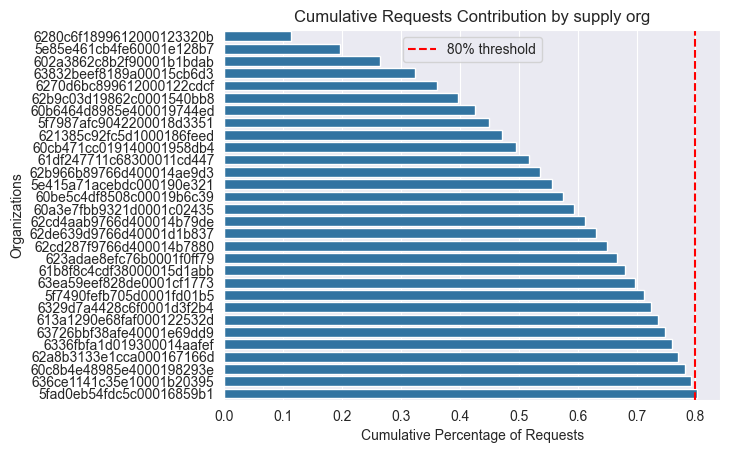

In [232]:
sns.barplot(data=df_result_4, x='cumulative_percentage', y='supply_org', orient='h')
plt.axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
plt.title('Cumulative Requests Contribution by supply org')
plt.xlabel('Cumulative Percentage of Requests')
plt.ylabel('Organizations')
plt.legend()
plt.show()

In [233]:
# 5

In [234]:
cursor = conn.cursor()
cursor.execute("ALTER TABLE spo_daily ADD COLUMN bid_rate REAL;")
cursor.execute("ALTER TABLE spo_daily ADD COLUMN win_rate REAL;")
cursor.execute("ALTER TABLE spo_daily ADD COLUMN success_rate REAL;")
cursor.execute("ALTER TABLE spo_daily ADD COLUMN fill_rate REAL;")
cursor.execute("ALTER TABLE spo_daily ADD COLUMN revenue_per_request REAL;")
cursor.execute("ALTER TABLE spo_daily ADD COLUMN cpm REAL;")

update_query = """
UPDATE spo_daily
SET
    bid_rate = CASE WHEN requests > 0 THEN bids * 1.0 / requests ELSE 0 END,
    win_rate = CASE WHEN bids > 0 THEN wins * 1.0 / bids ELSE 0 END,
    success_rate = CASE WHEN wins > 0 THEN impressions * 1.0 / wins ELSE 0 END,
    fill_rate = CASE WHEN requests > 0 THEN impressions * 1.0 / requests ELSE 0 END,
    revenue_per_request = CASE WHEN requests > 0 THEN ROUND(rev * 1.0 / requests, 9) ELSE 0 END,
    cpm = CASE WHEN impressions > 0 THEN 1000 * rev * 1.0 / impressions ELSE 0 END;
"""
cursor.execute(update_query)
conn.commit()


In [235]:
pd.set_option('display.float_format', '{:.9f}'.format)

query = '''
SELECT
    device_type,
    ROUND(AVG(cpm), 5) AS avg_cpm,
    ROUND(AVG(bid_rate), 5) AS avg_bid_rate,
    ROUND(AVG(success_rate), 5) AS avg_success_rate,
    ROUND(AVG(win_rate), 5) AS avg_win_rate,
    ROUND(AVG(revenue_per_request), 9) AS avg_revenue_per_request
FROM
    spo_daily
GROUP BY
    device_type;
'''

df_result_5 = pd.read_sql_query(query, conn)
df_result_5

,device_type,avg_cpm,avg_bid_rate,avg_success_rate,avg_win_rate,avg_revenue_per_request
0,Mobile/Tablet,2.224500000,0.021210000,0.469230000,0.695750000,0.000005629
1,Personal-Computer,3.167210000,0.049080000,0.245660000,0.626220000,0.000009712
2,Phone,3.280210000,0.053570000,0.268770000,0.666010000,0.000012721
3,Tablet,2.338380000,0.040390000,0.292620000,0.702010000,0.000009184


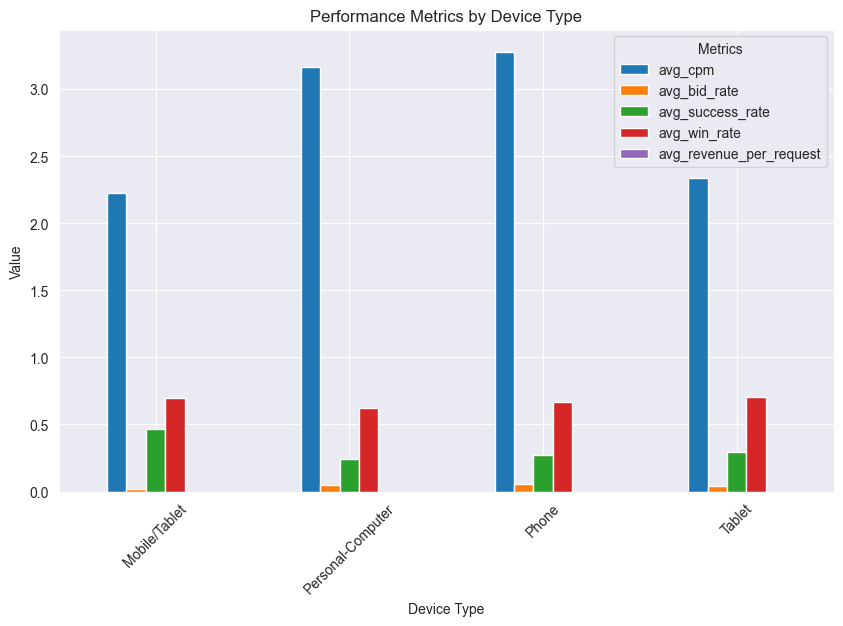

In [236]:
df_result_5.plot(
    kind='bar', x='device_type',
    y=['avg_cpm', 'avg_bid_rate', 'avg_success_rate', 'avg_win_rate', 'avg_revenue_per_request'],
    figsize=(10, 6)
)
plt.title('Performance Metrics by Device Type')
plt.ylabel('Value')
plt.xlabel('Device Type')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()


In [237]:
# 6

In [238]:
query = '''
SELECT
    domain,
    device_type,
    ROUND(AVG(cpm), 5) AS avg_cpm,
    ROUND(AVG(bid_rate), 5) AS avg_bid_rate,
    ROUND(AVG(success_rate), 5) AS avg_success_rate,
    ROUND(AVG(win_rate), 5) AS avg_win_rate,
    ROUND(AVG(CASE WHEN requests > 0 THEN rev * 1.0 / requests ELSE 0 END), 9) AS avg_revenue_per_request
FROM
    spo_daily
GROUP BY
    domain, device_type;

'''
df_result_6 = pd.read_sql_query(query, conn)
df_result_6

,domain,device_type,avg_cpm,avg_bid_rate,avg_success_rate,avg_win_rate,avg_revenue_per_request
0,None,Phone,0.808680000,0.022780000,0.004500000,0.300150000,0.000000903
1,None,Tablet,0.000000000,0.008530000,0.000000000,0.199290000,0.000000000
2,1001freefonts.com,Personal-Computer,2.269990000,0.055950000,0.045590000,0.494020000,0.000002468
3,1001juegos.com,Personal-Computer,1.536070000,0.075160000,0.228770000,0.634260000,0.000013790
4,101theeagle.com,Phone,6.500180000,0.004590000,0.255200000,0.766110000,0.000005081
...,...,...,...,...,...,...,...
2327,zeroto60times.com,Personal-Computer,0.412000000,0.000150000,0.166670000,0.555560000,0.000000040
2328,zmenu.com,Personal-Computer,3.873480000,0.133560000,0.016040000,0.497840000,0.000003422
2329,zmenu.com,Phone,4.357380000,0.027390000,0.006520000,0.548490000,0.000000663
2330,zumper.com,Personal-Computer,1.932590000,0.044900000,0.137510000,0.476550000,0.000004705


/var/folders/9t/msh0s7lj6nl9lmxf_kw6jlkm0000gn/T/ipykernel_92582/2424214688.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_domains, x='avg_cpm', y='domain', palette='viridis')
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-package

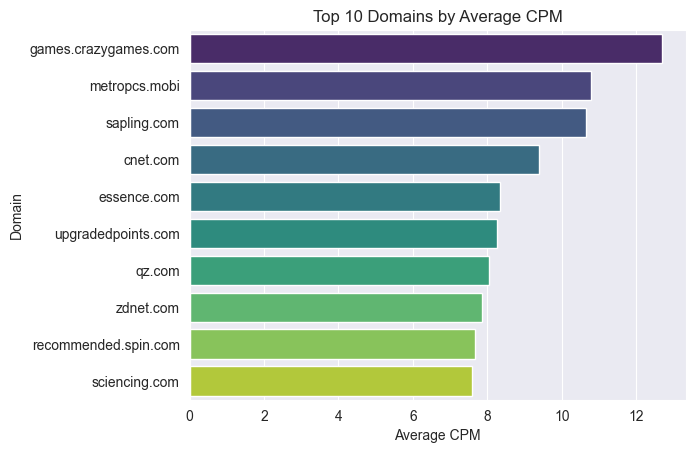

In [239]:
top_domains = df_result_6.groupby('domain')['avg_cpm'].mean().nlargest(10).reset_index()

sns.barplot(data=top_domains, x='avg_cpm', y='domain', palette='viridis')
plt.title('Top 10 Domains by Average CPM')
plt.xlabel('Average CPM')
plt.ylabel('Domain')
plt.show()


In [240]:
# 7

In [241]:
query = '''
WITH rr_per_advertiser AS (
    SELECT
        advertiserid,
        cookie_sync,
        ROUND(SUM(rev) * 1.0 / SUM(requests), 9) AS rr_per_cookie_sync
    FROM
        spo_daily
    GROUP BY
        advertiserid, cookie_sync
),
total_rr_per_advertiser AS (
    SELECT
        advertiserid,
        ROUND(SUM(rev) * 1.0 / SUM(requests), 9) AS total_rr
    FROM
        spo_daily
    GROUP BY
        advertiserid
)
SELECT
    rr_per_advertiser.advertiserid,
    rr_per_advertiser.cookie_sync,
    rr_per_advertiser.rr_per_cookie_sync,
    total_rr_per_advertiser.total_rr,
    ROUND(rr_per_advertiser.rr_per_cookie_sync / total_rr_per_advertiser.total_rr, 9) AS rr_divided_by_total
FROM
    rr_per_advertiser
JOIN
    total_rr_per_advertiser
ON
    rr_per_advertiser.advertiserid = total_rr_per_advertiser.advertiserid;


'''
df_result_7 = pd.read_sql_query(query, conn)
df_result_7

,advertiserid,cookie_sync,rr_per_cookie_sync,total_rr,rr_divided_by_total
0,magnite,0,0.000006335,0.000007223,0.877059394
1,magnite,1,0.000007500,0.000007223,1.038349716
2,pubmatic-new,0,0.000011068,0.000020499,0.539928777
3,pubmatic-new,1,0.000021723,0.000020499,1.059710230
4,sharethrough,0,0.000002251,0.000006298,0.357415052
5,sharethrough,1,0.000006877,0.000006298,1.091933947
6,xandr,0,0.000011497,0.000015890,0.723536816
7,xandr,1,0.000017238,0.000015890,1.084833228


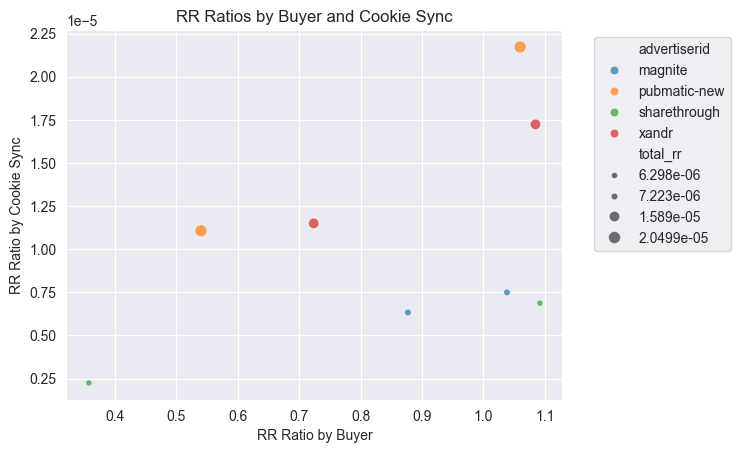

In [242]:
sns.scatterplot(
    data=df_result_7,
    x='rr_divided_by_total',
    y='rr_per_cookie_sync',
    size='total_rr',
    hue='advertiserid',
    alpha=0.7
)
plt.title('RR Ratios by Buyer and Cookie Sync')
plt.xlabel('RR Ratio by Buyer')
plt.ylabel('RR Ratio by Cookie Sync')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [243]:
# 8

In [244]:
query = '''
WITH rr_per_org AS (
    SELECT
        advertiserid,
        strftime('%d', replace(timestamp, ' UTC', '')) AS day,
        strftime('%H', replace(timestamp, ' UTC', '')) AS hour,
        supply_org,
        ROUND(SUM(rev) * 1.0 / SUM(requests), 9) AS rr
    FROM
        spo_daily
    GROUP BY
        advertiserid, day, hour, supply_org
),
ranked_rr AS (
    SELECT
        advertiserid,
        day,
        hour,
        supply_org,
        rr,
        ROW_NUMBER() OVER (PARTITION BY advertiserid, day, hour ORDER BY rr DESC) AS rank
    FROM
        rr_per_org
)
SELECT
    advertiserid,
    day,
    hour,
    supply_org,
    rr
FROM
    ranked_rr
WHERE
    rank <= 3
ORDER BY
    advertiserid, day, hour, rank;

'''
df_result_8 = pd.read_sql_query(query, conn)
df_result_8

,advertiserid,day,hour,supply_org,rr
0,magnite,01,00,5e7b914ccb4fe60001792de3,0.000087661
1,magnite,01,00,63d66fa866569400014f36da,0.000040237
2,magnite,01,00,620b92f782ae5000010e2d52,0.000036378
3,magnite,01,01,5e7b914ccb4fe60001792de3,0.000074216
4,magnite,01,01,62b322f79766d400014ac505,0.000035353
...,...,...,...,...,...
859,xandr,30,22,637e6582f8189a00015c9917,0.000075470
860,xandr,30,22,60c8b4e48985e4000198293e,0.000044963
861,xandr,30,23,61e0230c0f798300013f0ee9,0.000105532
862,xandr,30,23,637e6582f8189a00015c9917,0.000046426


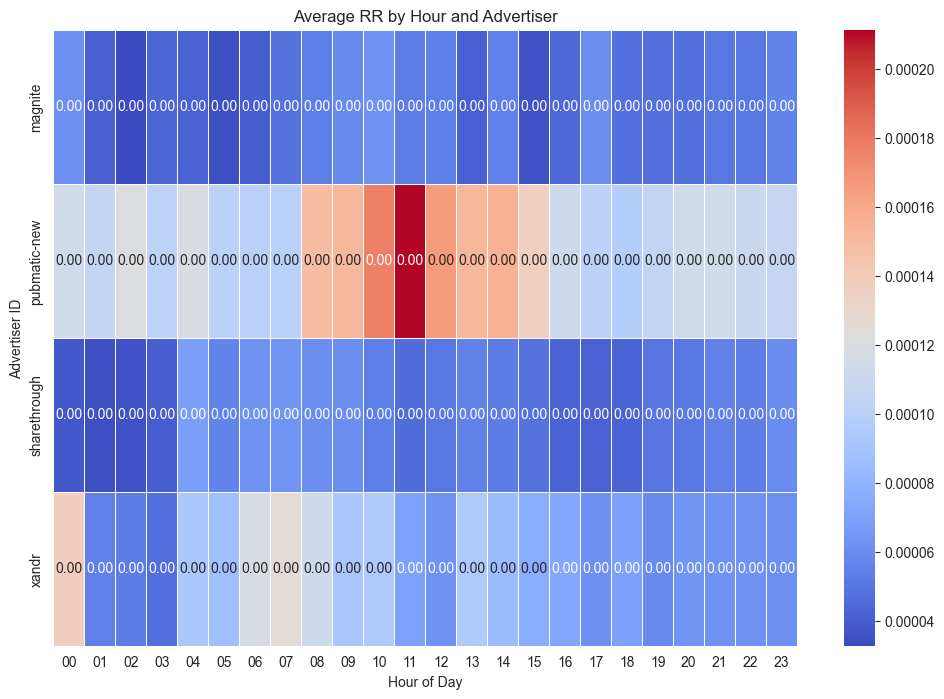

In [245]:
heatmap_data = df_result_8.pivot_table(
    index='advertiserid',
    columns='hour',
    values='rr',
    aggfunc='mean'
)
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Average RR by Hour and Advertiser')
plt.xlabel('Hour of Day')
plt.ylabel('Advertiser ID')
plt.show()


#EDA
Provide a detailed EDA, including feature engineering, data imputation (if needed), features extraction, empirical evidence, results and AI's.(Coding)


### Feature Engineering:
1. **Rate Features**:
   - Create proportional metrics (e.g., bid rate, win rate).

2. **Time-based Features**:
   - Generate features like the hour of the day or day of the week to capture seasonal effects.

3. **Lag Features - If I would have more time**:
   - Use autocorrelation analysis or perform signal decomposition to determine optimal lag values.
    - Add lags of the same time -24hors, lag of the previous hour, etc..
   - Use Fourier transforms if a larger dataset is available to capture periodic patterns.
   - **Important note**: The dataset covers only four days, so any identified trends must be interpreted cautiously. These could reflect seasonality, which requires more data to verify, rather than true changes over time.

4. **One-Hot Encoding for Categorical Features - If I would have more time**:
   - Apply one-hot encoding to categorical features except for `supply_org` and `domain`, which are high-cardinality features.
   - For high-cardinality features, I suggest clustering techniques (e.g., K-means or hierarchical clustering) to reduce dimensionality and group similar categories, if time permits.

5. **Signal Processing Features - If I would have more time**:
    - change between current value to the one before (diff/ratio) to detect increase and decrees of the signal.
    - AUC of the day before, and ratio of the current AUC to the previous AUC

---

### Data Imputation:
- Missing values were not imputed due to a lack of domain-specific knowledge.
- Features like `country` and `SaaStype`, containing only one value, were ignored.

---

### Outlier Removal:
- Analyzed the distributions of numerical features and identified extreme values (e.g., above the 99th percentile). However, due to time constraints, these outliers were not removed.

---

### Data Scaling and Bias Fix- If I would have more time:
- I will consider scale the numerical features, depends on the algorithm I would like to use for predictions.
- I would also try to fix the bias between the categorical features (as we can see in the "value_counts" analysis.
---


### Results:
1. **Advertiser Analysis - highlighting potential "low-value" traffic issues**:
   - Seasonal trends are apparent across advertisers, highlighting potential "low-value" traffic issues.
   - Examples:
     - Most advertisers, except *Xandr*, exhibit increased error rates on the last day, possibly due to weekend patterns or anomalies.
      - *HeraldWeekly* has the highest error rate but shows no increase over time.

2**Category Insights - highlighting potential "low-value" traffic issues**:
   - *Adtype banner* and *OS Windows* show an increase in error rates.
   - Personal computers and cookie-synced traffic also exhibit higher error rates.
   - Group 0 shows an increase in error rates on the last day.

3**Seasonality**:
   - Metrics decrease from 4 AM to 11 AM, reaching the lowest point at 8 AM.
   - Top domain breakdowns reveal recurring patterns across metrics.

4**Correlation Insights**:
- Perfect negative correlation (-1) between bid rate and error rate.
- Negative correlation between high incoming floor prices and revenue, suggesting inefficiency.

---

### Conclusion:
- Data signals an increase in error rates, potentially driven by weekly seasonality.
- Caution is necessary, as trends could reflect seasonal patterns rather than structural issues.
- Future analysis should focus on gathering more data to confirm seasonality and trends.

### Next:
-Find more relationships between more than one category type to numeric metrics ( advertisers, os and rev for example) (could use trees to find this)


In [256]:
df['bid_rate'] = df['bids'] / df['requests']
df['win_rate'] = df['wins'] / df['bids']
df['impression_rate'] = df['impressions'] / df['requests']
df['error_rate'] = df['errors'] / df['requests']
df['revenue_per_request'] = df['rev'] / df['requests']
df['cpm'] = 1000 * (df['rev'] / df['impressions'])
df['success_rate'] = df['impressions'] / df['wins']

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.date
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

In [257]:
metrics = ['requests', 'bids', 'impressions', 'wins', 'rev', 'revenue_per_request', 'win_rate', 'impression_rate', 'error_rate', 'cpm', 'bid_rate', 'success_rate']
categories = ['adtype', 'os', 'device_type', 'cookie_sync', 'advertiserid', 'IncomingFloor_grp']

In [140]:
df.isnull().sum()

timestamp                  0
supply_org                 0
SaaStype                   0
domain                    56
country                    0
adtype                     0
os                         0
device_type                0
cookie_sync                0
IncomingFloor_grp          0
advertiserid               0
requests                   0
bids                       0
errors                     0
wins                       0
impressions                0
rev                        0
bid_rate                   0
win_rate               19951
impression_rate            0
error_rate                 0
revenue_per_request        0
cpm                    35046
success_rate           20441
hour                       0
day                        0
day_of_week                0
dtype: int64

In [141]:
# I will not fill missing values due to their low occurrence and a lack of domain knowledge.

In [142]:
df.describe()

/opt/homebrew/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,cookie_sync,IncomingFloor_grp,requests,bids,errors,wins,impressions,rev,bid_rate,win_rate,impression_rate,error_rate,revenue_per_request,cpm,success_rate,hour,day_of_week
count,475933.00,475933.00,475933.00,475933.00,475933.00,475933.00,475933.00,475933.00,475933.00,455982.00,475933.00,475933.00,475933.00,440887.00,455492.00,475933.00,475933.00
mean,0.75,1.07,86421.57,3912.51,82509.06,2309.78,442.84,0.91,0.05,0.71,0.00,0.95,0.00,3.37,inf,12.50,1.90
std,0.44,2.00,563296.80,19582.52,556394.38,12057.06,2966.54,4.53,0.09,0.23,0.01,0.09,0.00,3.04,NaN,7.24,2.23
min,0.00,0.00,10001.00,0.00,1232.00,0.00,0.00,0.00,0.00,0.00,0.00,0.11,0.00,0.01,0.00,0.00,0.00
25%,0.00,0.00,14606.00,86.00,13878.00,63.00,13.00,0.03,0.00,0.55,0.00,0.94,0.00,1.56,0.09,5.00,0.00
50%,1.00,0.00,24352.00,520.00,23109.00,339.00,58.00,0.15,0.02,0.74,0.00,0.98,0.00,2.54,0.20,14.00,1.00
75%,1.00,1.00,54312.00,2175.00,51344.00,1305.00,200.00,0.54,0.06,0.91,0.01,1.00,0.00,4.21,0.40,19.00,2.00
max,1.00,39.00,97119302.00,1325042.00,96923067.00,698906.00,331929.00,327.93,0.89,1.00,0.24,1.00,0.00,84.28,inf,23.00,6.00


In [143]:
df.duplicated().sum()

0

In [144]:
df.supply_org.nunique()

137

In [145]:
#high-cardinality feature

In [146]:
df.groupby(['supply_org'])['timestamp'].count().describe()

count     137.00
mean     3473.96
std      5889.73
min         7.00
25%       440.00
50%      1691.00
75%      3404.00
max     30535.00
Name: timestamp, dtype: float64

In [147]:
df['SaaStype'].value_counts()

SaaStype
RISE    475933
Name: count, dtype: int64

In [148]:
# we can ignore this feature

In [149]:
df['domain'].nunique()

1283

In [150]:
#high-cardinality feature

In [151]:
df.groupby(['domain'])['timestamp'].count().describe()

count    1283.00
mean      370.91
std       805.61
min         1.00
25%        15.00
50%        90.00
75%       373.00
max     14948.00
Name: timestamp, dtype: float64

In [152]:
df['country'].value_counts()

country
USA    475933
Name: count, dtype: int64

In [153]:
# we can ignore this feature

In [154]:
df['adtype'].value_counts()

adtype
banner    350181
video     125752
Name: count, dtype: int64

In [155]:
df['os'].value_counts()

os
Android      206529
Windows      143339
iOS           64464
Mac OS X      44518
Chrome OS     16184
Linux           836
Ubuntu           53
Other            10
Name: count, dtype: int64

In [156]:
df['cookie_sync'].value_counts()

cookie_sync
1    354932
0    121001
Name: count, dtype: int64

In [157]:
df['IncomingFloor_grp'].value_counts()

IncomingFloor_grp
0     276189
1      94006
2      32405
3      26321
4      19601
5      12368
6       5168
7       2833
8       1863
12      1087
13       988
9        723
11       539
10       530
17       379
19       327
14       199
16       163
15       119
20        50
25        36
39        22
18        17
Name: count, dtype: int64

In [158]:
df['advertiserid'].value_counts()

advertiserid
sharethrough    146075
magnite         106663
yahoo            82563
xandr            70452
pubmatic-new     70180
Name: count, dtype: int64

In [171]:
df.day.value_counts()

day
2023-05-02    171594
2023-05-01    142273
2023-04-30    102552
2023-05-03     59514
Name: count, dtype: int64

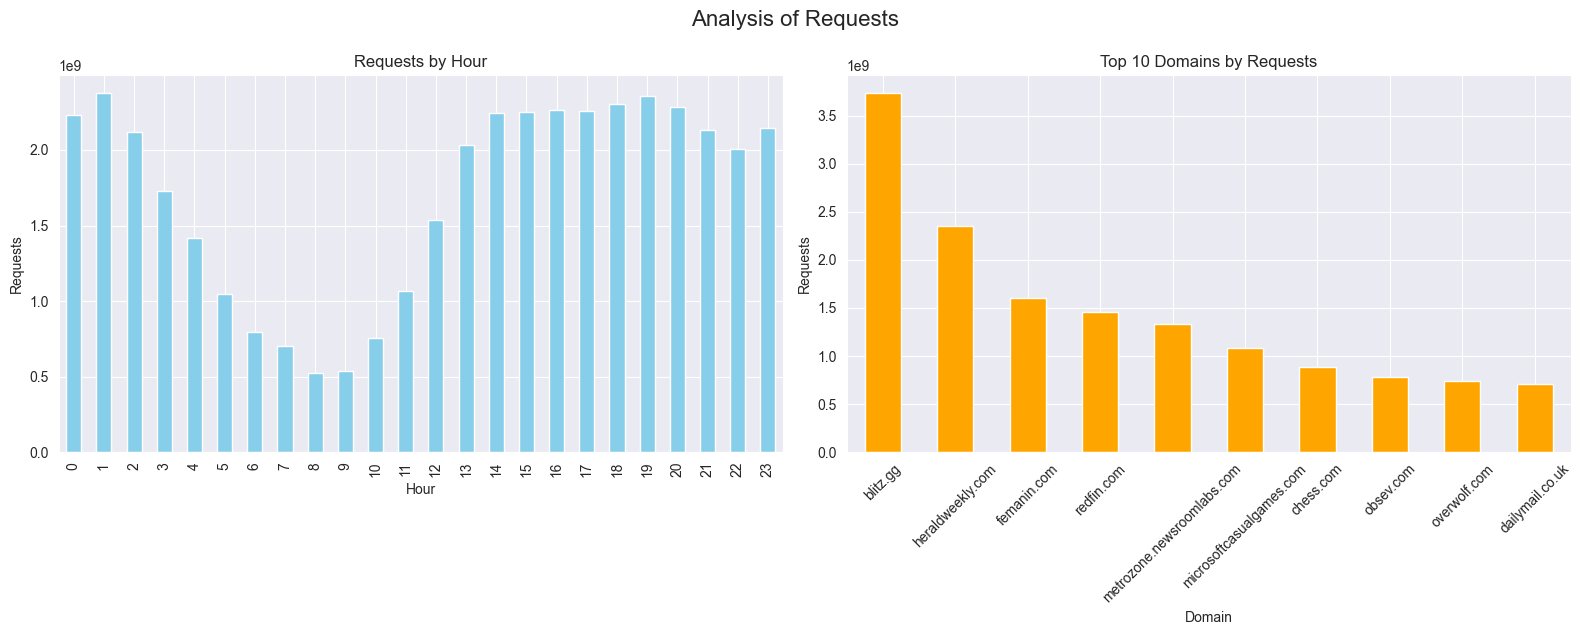

In [168]:
# I will show only one graph here because they all look the same
for cc in [metrics[0]]: # metrics:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    df.groupby('hour')[cc].sum().plot(
        kind='bar', ax=axes[0], color='skyblue', title=f'{cc.capitalize()} by Hour'
    )
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel(cc.capitalize())

    top_domains = df.groupby('domain')[cc].sum().nlargest(10)
    top_domains.plot(
        kind='bar', ax=axes[1], color='orange', title=f'Top 10 Domains by {cc.capitalize()}'
    )
    axes[1].set_xlabel('Domain')
    axes[1].set_ylabel(cc.capitalize())
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.suptitle(f'Analysis of {cc.capitalize()}', fontsize=16, y=1.05)
    plt.show()


In [ ]:
# Clear seasonality observed, with vally requests at 8 AM.

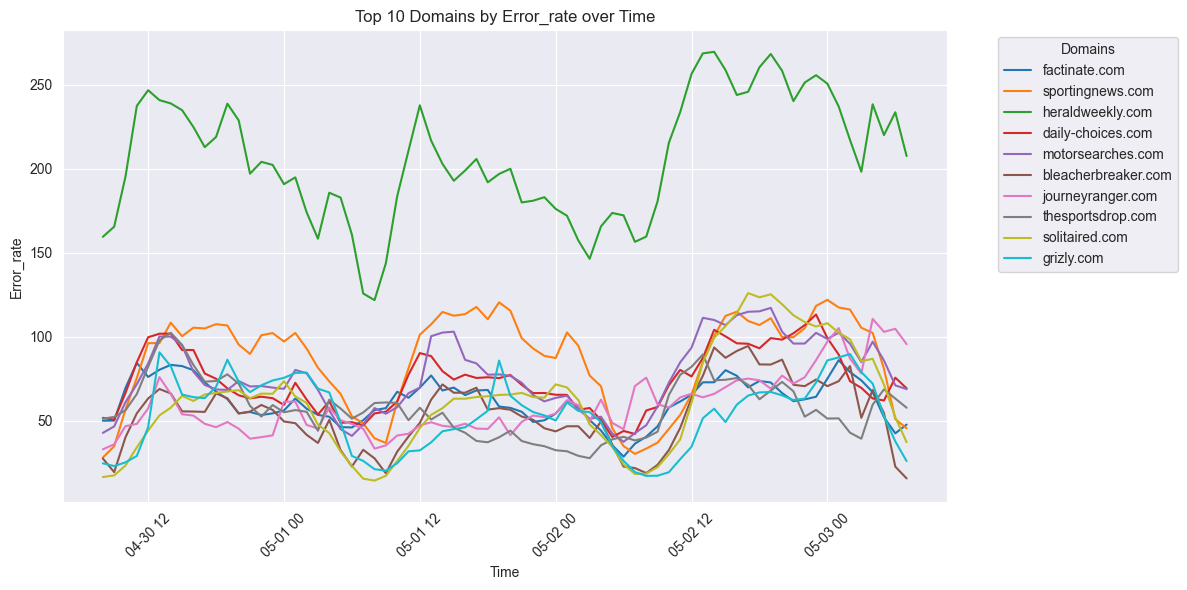

In [283]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    top_domains = df.groupby('domain')[cc].sum().nlargest(10)
    top_domains_data = df[df['domain'].isin(top_domains.index)]

    plt.figure(figsize=(12, 6))
    for domain in top_domains_data['domain'].unique():
        domain_data = top_domains_data[top_domains_data['domain'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'Top 10 Domains by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='Domains', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [172]:
# blitz.gg experienced a significant increase in requests on the last day.
# microsoftcausalgames had the highest number of impressions.
# heraldweekly recorded the highest win rate and error rate.
# femanin and heraldweekly showed a decline in revenue.
# solitaries demonstrated a decrease in impression rate.
# games.crazygames and heraldweekly had the highest CPM.
# Most of the data shows clear seasonality, likely influenced by human behavior patterns.

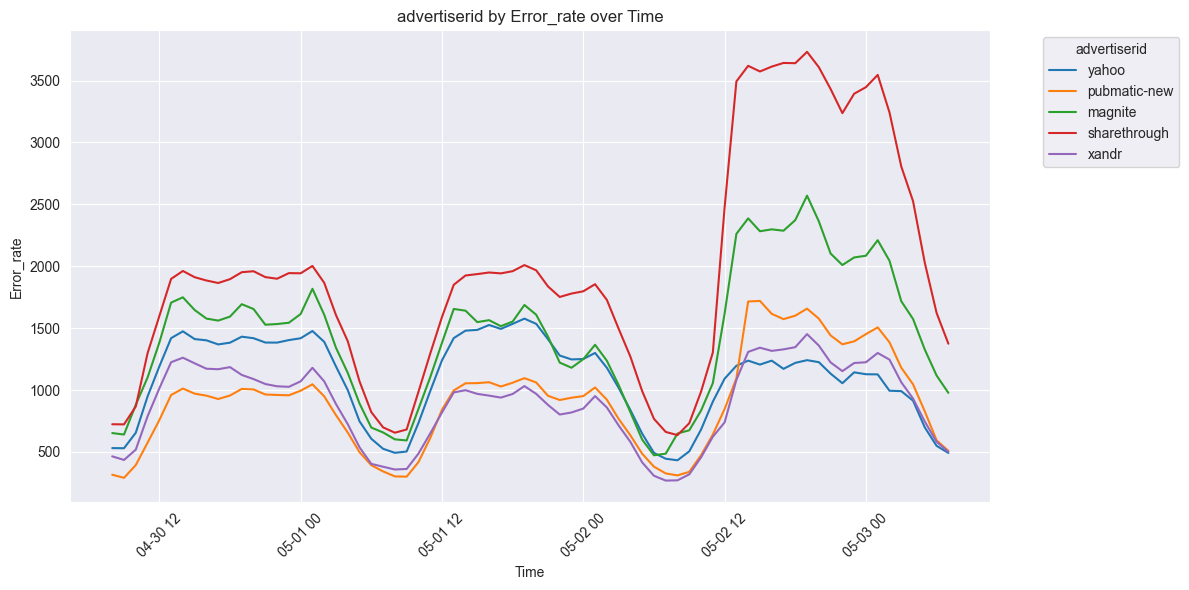

In [282]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:

    plt.figure(figsize=(12, 6))
    for domain in df['advertiserid'].unique():
        domain_data = df[df['advertiserid'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'advertiserid by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='advertiserid', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# Sharethrough is showing increases in requests, bids, impressions, wins, revenue, win rate, error rate, CPM, and success rate.
# Xandr has relatively high bids but a decrease in wins.
# PubMatic is experiencing an increase in wins, error rate, and CPM.
# Yahoo is showing a decrease in impressions, win rate, and success rate.
# Magnite is showing an increase in error rate and CPM.

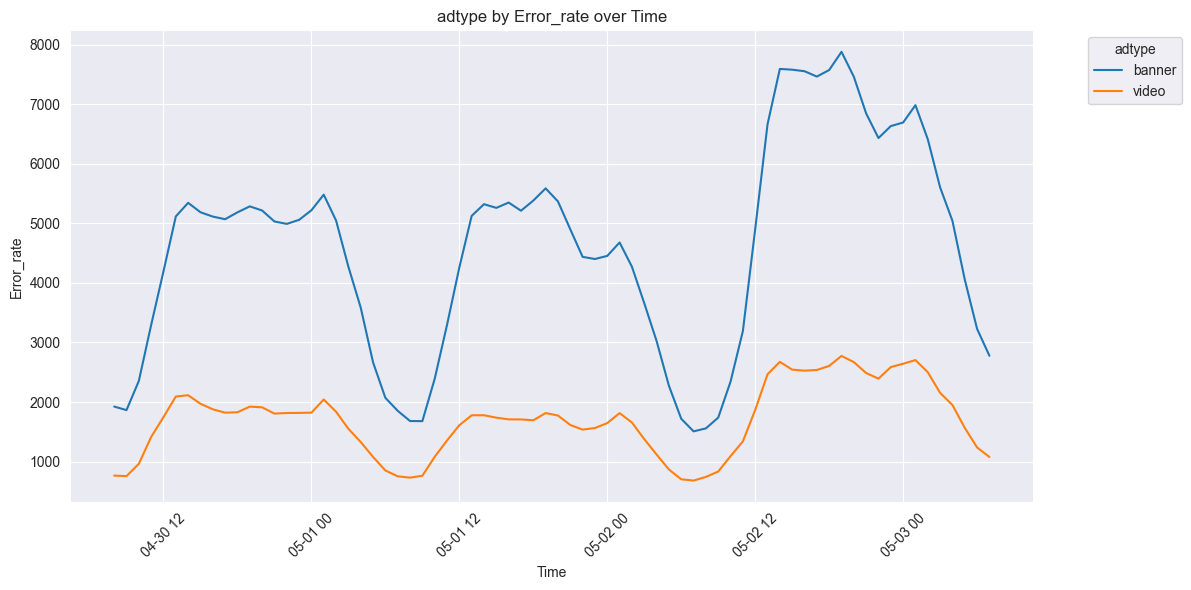

In [281]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    plt.figure(figsize=(12, 6))
    for domain in df['adtype'].unique():
        domain_data = df[df['adtype'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'adtype by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='adtype', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# Banners outperform videos in almost every metric, with CPM being quite similar for both.

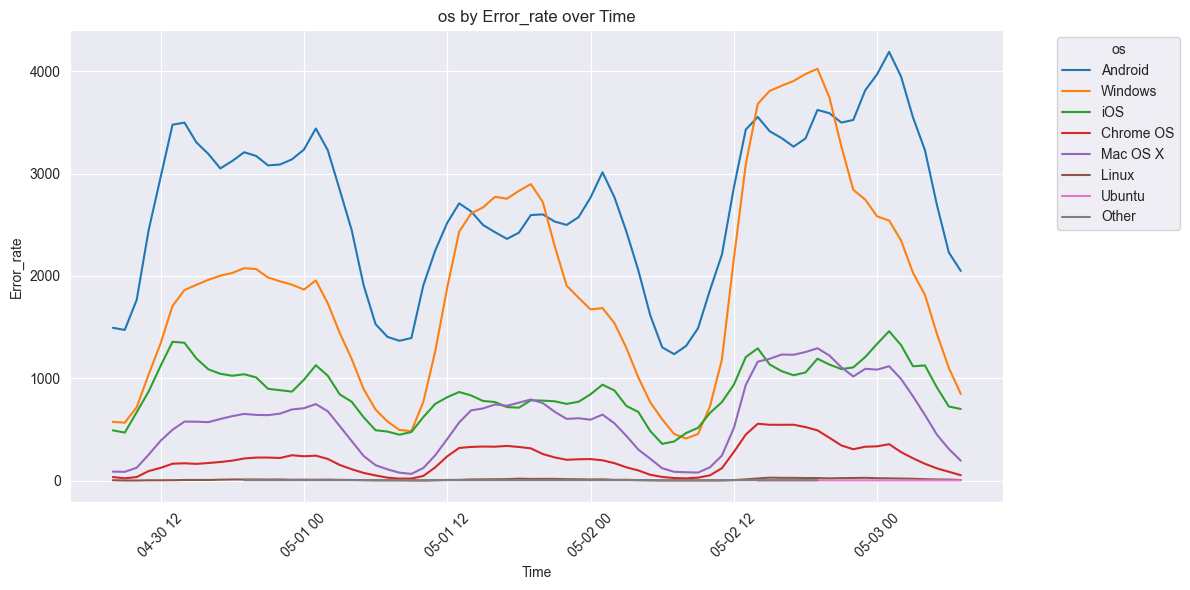

In [280]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    plt.figure(figsize=(12, 6))
    for domain in df['os'].unique():
        domain_data = df[df['os'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'os by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='os', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# Android and Windows perform the best across most metrics

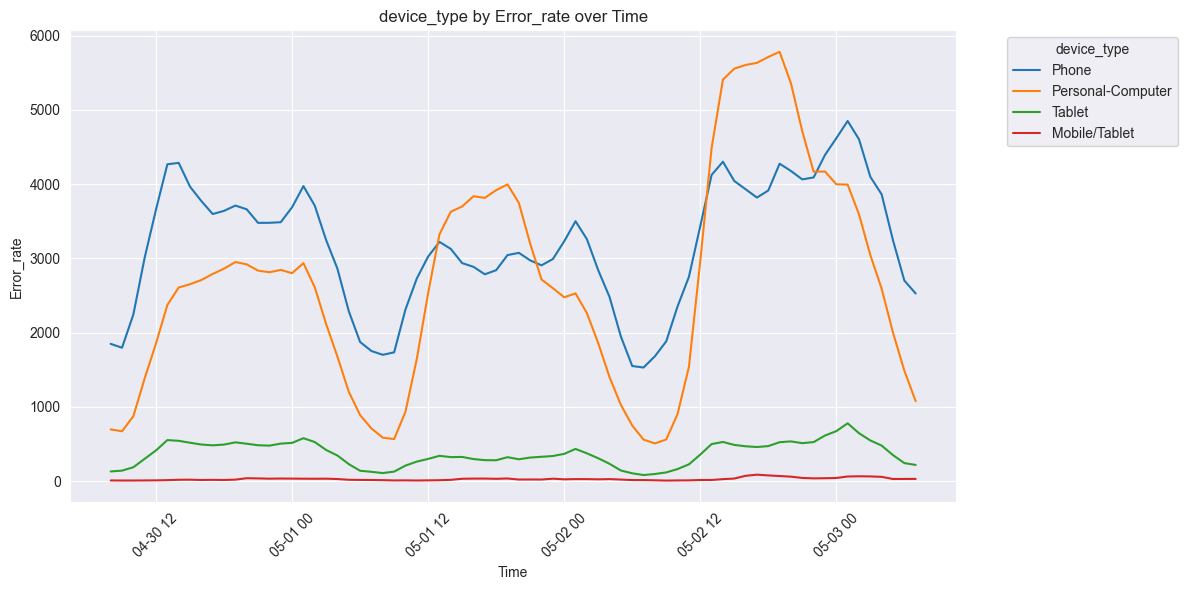

In [279]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    plt.figure(figsize=(12, 6))
    for domain in df['device_type'].unique():
        domain_data = df[df['device_type'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'device_type by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='device_type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# Phone and Personal Computer perform the best across most metrics

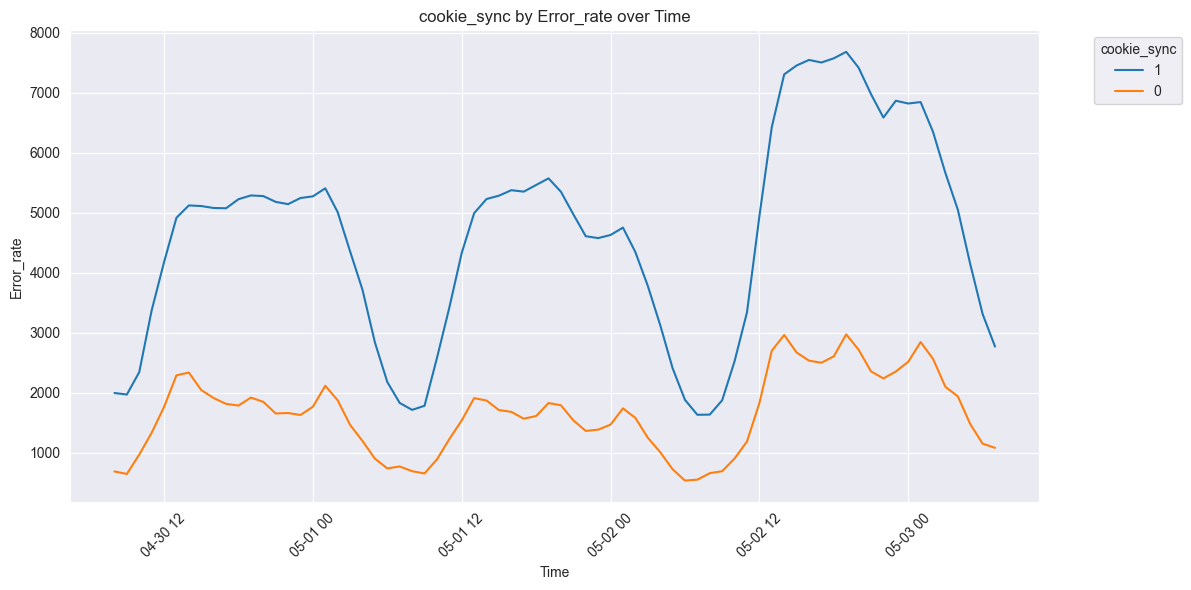

In [278]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    plt.figure(figsize=(12, 6))
    for domain in df['cookie_sync'].unique():
        domain_data = df[df['cookie_sync'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'cookie_sync by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='cookie_sync', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# The majority of the data is cookie-synced, with an increase in requests and bids observed in the synced group.

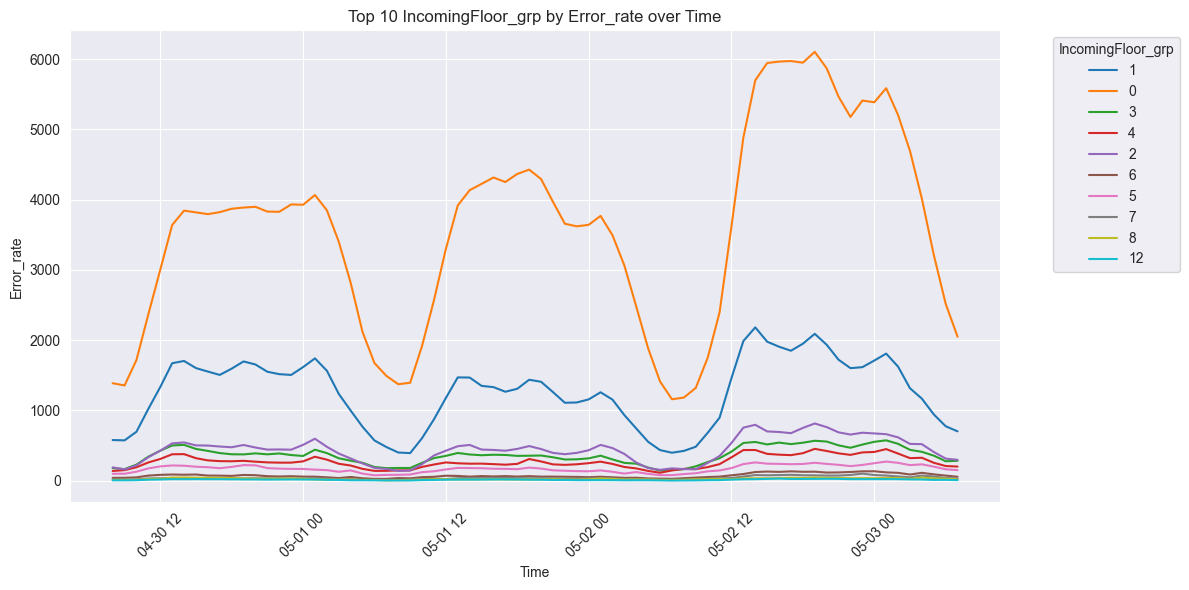

In [290]:
# I will show here just one example, I summarized all the results in the next cell
for cc in ['error_rate']:#[metrics[0]]:#metrics:
    top_domains = df.groupby('IncomingFloor_grp')[cc].sum().nlargest(10)
    top_domains_data = df[df['IncomingFloor_grp'].isin(top_domains.index)]
    # top_domains_data = top_domains_data[top_domains_data['IncomingFloor_grp'] != 0]
    # top_domains_data = top_domains_data[top_domains_data['IncomingFloor_grp'] != 1]


    plt.figure(figsize=(12, 6))
    for domain in top_domains_data['IncomingFloor_grp'].unique():
        domain_data = top_domains_data[top_domains_data['IncomingFloor_grp'] == domain]
        domain_data = domain_data.groupby('timestamp')[cc].sum()
        plt.plot(domain_data.index, domain_data.values, label=domain)

    plt.title(f'Top 10 IncomingFloor_grp by {cc.capitalize()} over Time')
    plt.xlabel('Time')
    plt.ylabel(cc.capitalize())
    plt.legend(title='IncomingFloor_grp', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [ ]:
# There is an increase in requests, bids, errors, and CPM in both Group 0 and Group 1.

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

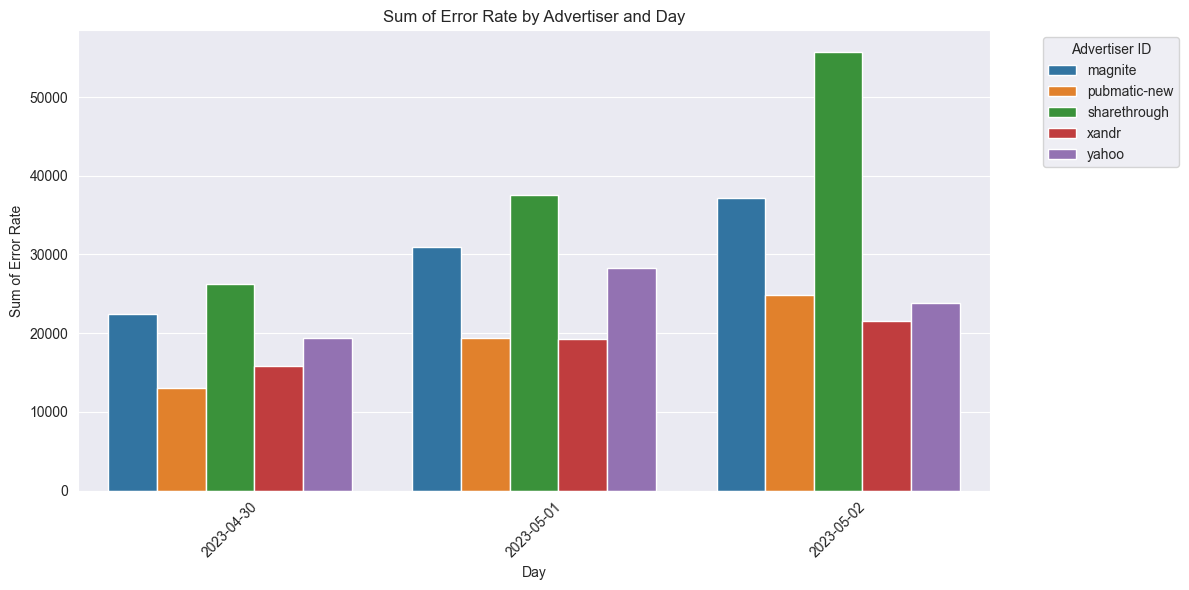

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

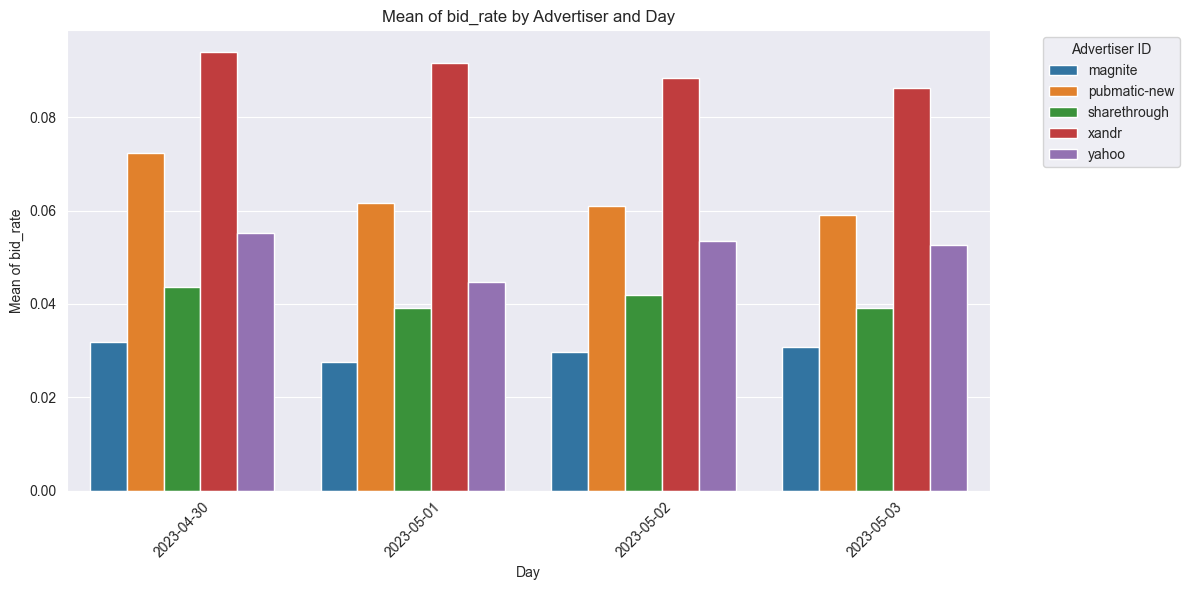

/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWa

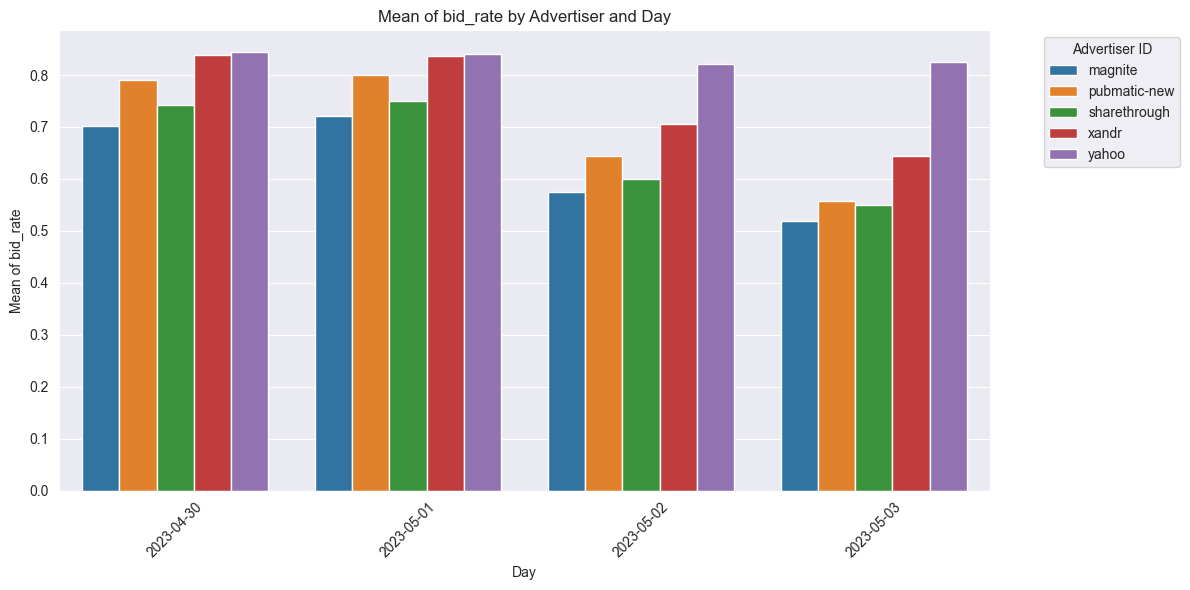

In [305]:
# Low quality is characterized by high errors, low bids and low wins.

df_plot = df[df['timestamp']<'2023-05-03 00:00:00'] #(ignor 2023-05-03 as it is not a full day)
error_rate_by_advertiser_day = df_plot.groupby(['advertiserid', 'day'])['error_rate'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=error_rate_by_advertiser_day, x='day', y='error_rate', hue='advertiserid')
plt.title('Sum of Error Rate by Advertiser and Day')
plt.xlabel('Day')
plt.ylabel('Sum of Error Rate')
plt.xticks(rotation=45)
plt.legend(title='Advertiser ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# df_plot = df[df['timestamp']<'2023-05-03 00:00:00'] #(ignor 2023-05-03 as it is not a full day)
df_plot = df.copy()
error_rate_by_advertiser_day = df_plot.groupby(['advertiserid', 'day'])['bid_rate'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=error_rate_by_advertiser_day, x='day', y='bid_rate', hue='advertiserid')
plt.title('Mean of bid_rate by Advertiser and Day')
plt.xlabel('Day')
plt.ylabel('Mean of bid_rate')
plt.xticks(rotation=45)
plt.legend(title='Advertiser ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# df_plot = df[df['timestamp']<'2023-05-03 00:00:00'] #(ignor 2023-05-03 as it is not a full day)
df_plot = df.copy()
error_rate_by_advertiser_day = df_plot.groupby(['advertiserid', 'day'])['win_rate'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=error_rate_by_advertiser_day, x='day', y='win_rate', hue='advertiserid')
plt.title('Mean of bid_rate by Advertiser and Day')
plt.xlabel('Day')
plt.ylabel('Mean of bid_rate')
plt.xticks(rotation=45)
plt.legend(title='Advertiser ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# It is evident that most of the advertisers show an increase in their error rates, and small decreese in avg bid_rate and win_rate.

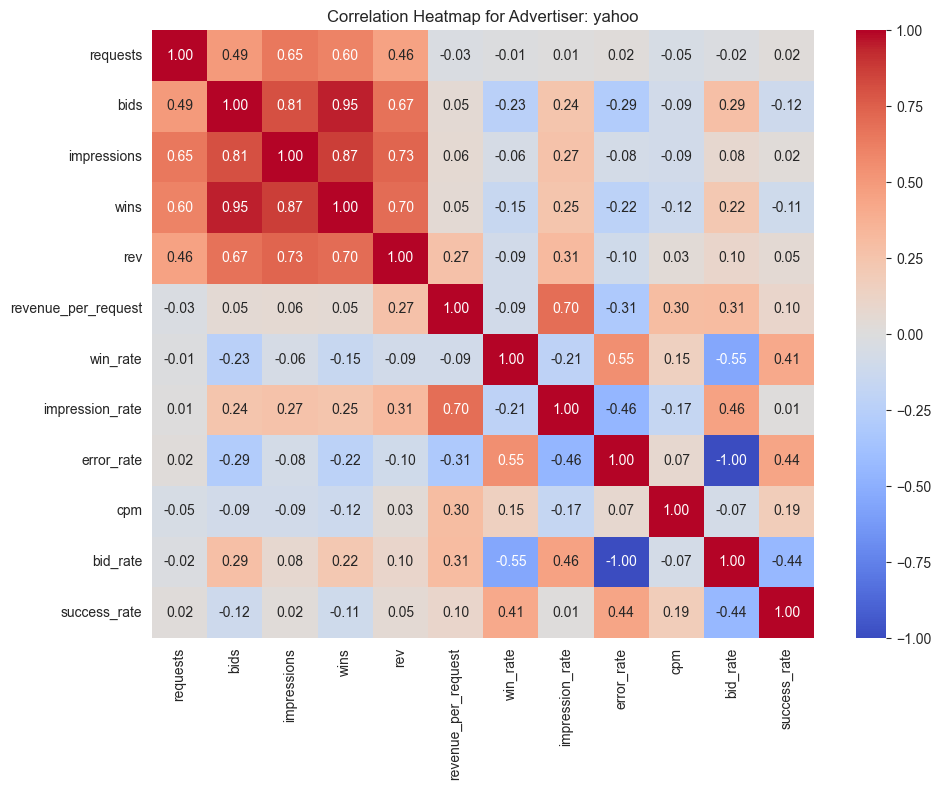

In [189]:
# I will show here just one example, I summarized all the results in the next cell
df_metrics = df[['advertiserid'] + metrics]

for advertiser in [df_metrics['advertiserid'].unique()[0]]:#df_metrics['advertiserid'].unique():
    advertiser_data = df_metrics[df_metrics['advertiserid'] == advertiser]
    correlation_matrix = advertiser_data[metrics].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(f'Correlation Heatmap for Advertiser: {advertiser}')
    plt.tight_layout()
    plt.show()


In [ ]:
# The heatmaps for all advertiser IDs show similar patterns.
# There is a perfect negative correlation (-1) between bid rate and error rate.
# There are very high positive correlations (ranging from 0.49 to 0.95) between the basic metrics (bids, wins, impressions, requests, and revenue).

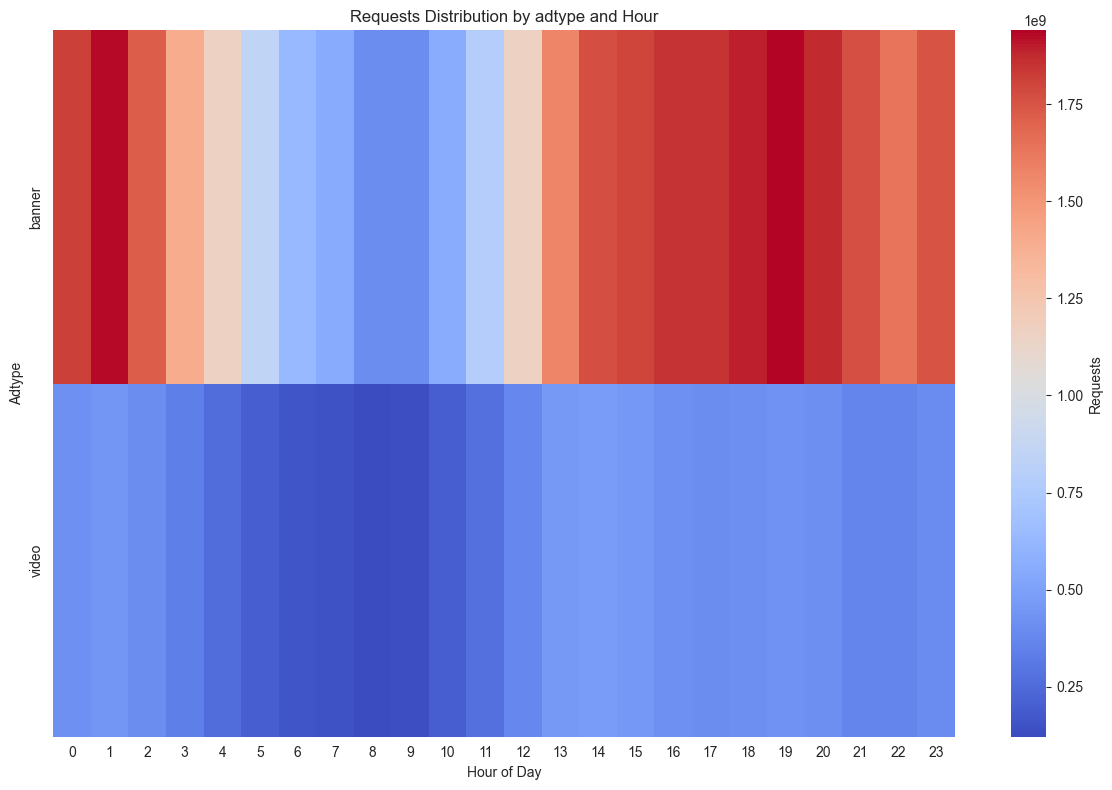

In [190]:
# I will show here just one example, I summarized all the results in the next cell
for category in [categories[0]]:#categories:
    for metric in [metrics[0]]:#metrics:
        metric_distribution = df.groupby([category, 'hour'])[metric].sum().reset_index()
        metric_pivot = metric_distribution.pivot(index=category, columns='hour', values=metric).fillna(0)

        plt.figure(figsize=(12, 8))
        sns.heatmap(metric_pivot, cmap='coolwarm', annot=False, fmt='.0f', cbar_kws={'label': f'{metric.capitalize()}'})
        plt.title(f'{metric.capitalize()} Distribution by {category} and Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel(category.capitalize())
        plt.tight_layout()
        plt.show()


In [ ]:
# Most of the activity occurs between noon and 3 AM.

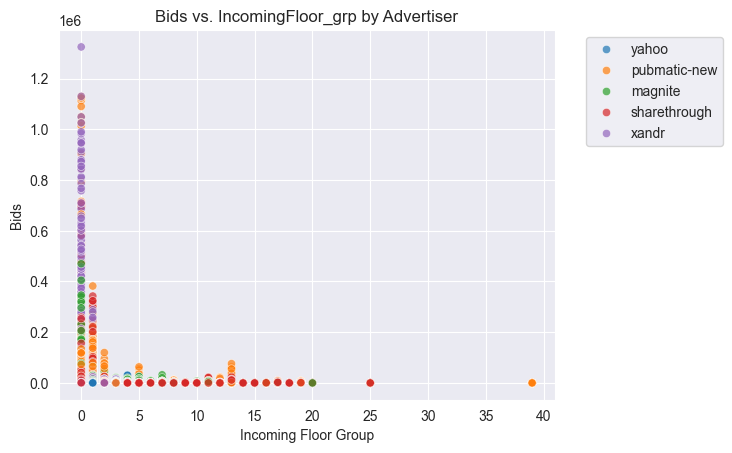

In [77]:
sns.scatterplot(data=df, x='IncomingFloor_grp', y='bids', hue='advertiserid', alpha=0.7)
plt.title('Bids vs. IncomingFloor_grp by Advertiser')
plt.xlabel('Incoming Floor Group')
plt.ylabel('Bids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# It seems that there are no bids for high Incoming Floor Groups. Is this not providing any benefit?

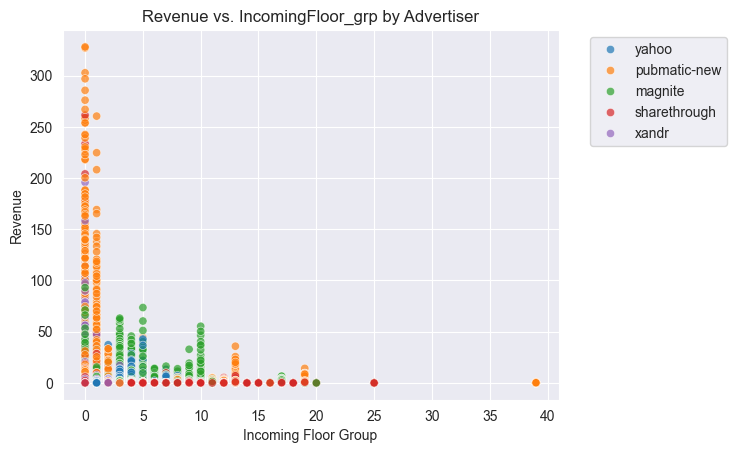

In [215]:
sns.scatterplot(data=df, x='IncomingFloor_grp', y='rev', hue='advertiserid', alpha=0.7)
plt.title('Revenue vs. IncomingFloor_grp by Advertiser')
plt.xlabel('Incoming Floor Group')
plt.ylabel('Revenue')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# It appears that high floor prices are not positively correlated with high revenue.

In [249]:
#not high cardenality features
df = pd.get_dummies(df, columns=categories, drop_first=True)
print(df.head())


                 timestamp                supply_org SaaStype  \
0  2023-05-02 11:00:00 UTC  611bdc67e3ca550001dcab87     RISE   
1  2023-04-30 15:00:00 UTC  63cfc781d86b350001d23dad     RISE   
2  2023-05-02 19:00:00 UTC  628e155f3c8195000177d1ec     RISE   
3  2023-05-02 20:00:00 UTC  5e85e461cb4fe60001e128b7     RISE   
4  2023-05-02 03:00:00 UTC  5e85e461cb4fe60001e128b7     RISE   

                domain country  requests   bids    errors   wins  impressions  \
0  historyobsessed.com     USA     17841    436     17405    349           48   
1        thekitchn.com     USA     14553   3117     11436   1271           71   
2       healthdish.com     USA     23543      0     23543      0            0   
3             blitz.gg     USA     80866      3     80863      2            0   
4             blitz.gg     USA  22716538  30561  22685977  29133        14734   

   ...  IncomingFloor_grp_13  IncomingFloor_grp_14  IncomingFloor_grp_15  \
0  ...                 False                 F

In [ ]:
# lags:
import pandas as pd

# Assume your dataframe is named 'df'
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp (if not already sorted)
df = df.sort_values(by=['advertiserid', 'timestamp'])

# Add lag features (lag of 1 hour)
df['requests_lag_1'] = df.groupby('advertiserid')['requests'].shift(1)
df['bids_lag_1'] = df.groupby('advertiserid')['bids'].shift(1)
df['errors_lag_1'] = df.groupby('advertiserid')['errors'].shift(1)

# Calculate the difference between current and previous values
df['requests_diff'] = df['requests'] - df['requests_lag_1']
df['bids_diff'] = df['bids'] - df['bids_lag_1']
df['errors_diff'] = df['errors'] - df['errors_lag_1']

# Handle missing values (for first row in each group after shifting)
df.fillna(0, inplace=True)  # You can also choose other imputation methods if needed

# Check the result
print(df[['advertiserid', 'timestamp', 'requests', 'requests_lag_1', 'requests_diff', 'bids', 'bids_lag_1', 'bids_diff', 'errors', 'errors_lag_1', 'errors_diff']].head())


#Algorithm
Design an ML solution. Explain your algorithm approach, the possible contradictions and how we plan to tackle them. Implement your solution (pseudo code is accepted), including algorithm validation and evaluation functions. (Theoretical/Coding)

In [ ]:
#Problem:
#Improving demand partner performance by identifying and addressing low-value traffic.
#The Goal:
#Classify traffic as "low-value" or "high-value" (binary classifier)
#The Target:
#Label the traffic as low-value (0) or high-value (1) based on whether it resulted in bids or not
#Evaluation Metrics:
# f1 score, PR-AUC

In [ ]:
# I will gather 2 years' worth of traffic data to capture various seasonality patterns across multiple timeframes: yearly, monthly, weekly, daily, and hourly.

# Features:
# Request Characteristics: Metrics such as total requests, bid rate, win rate, and errors.
# Advertiser-Specific Data: Information on advertisers, including their domain of interest, campaign performance, and any other relevant metrics.
# Time-Related Features: Time-stamps to capture seasonality, including hour of the day, day of the week, month, and year.
# Traffic Sources: Information on where the traffic is coming from, including referrers, devices (e.g., mobile, desktop), and geo-location (country, region, city).
# Ad Type & Format: Details on the types of ads (e.g., banner, video), formats, and associated performance metrics.
# Floor Prices: Data on the floor prices and their relation to actual bid values, helping to understand pricing trends and demand.
# Performance Metrics: Such as impressions, click-through rates (CTR), conversion rates, and error rates.
# User & Device Attributes: Data on user profiles, device types, operating systems, and browser versions.

In [ ]:
#Data Preprocessing & Transformation
# Handle missing values (impute or drop depending on the data quality).
# Normalize/standardize features (especially for metrics like requests, bids, cpm, error_rate which can vary in magnitude).
# Feature engineering (e.g., calculating bid success ratio, error rate trends, and lag features).
# One-hot encode categorical features (like advertiserid, os, etc.).

In [ ]:
# Model Selection:
# Random Forest: Handles both numerical and categorical data, performs well on imbalanced datasets, and offers feature importance insights.
# Gradient Boosting (XGBoost/LightGBM): Effective for high-dimensional data and imbalanced classes, can be optimized through hyperparameter tuning.
# Logistic Regression: Useful for baseline models and linear separability but may struggle with non-linear relationships.
# Neural Networks: If there is enough data and complexity, neural networks can model intricate relationships but require more computational resources.

In [ ]:
#Train the Model:
# Split the data into training and testing sets with a 20-80 ratio, ensuring that the temporal aspect is respected to avoid data leakage. Additionally, I will account for any class imbalances by using stratified splitting, ensuring that the distribution of target values is preserved in both the training and testing sets.

In [ ]:
# Validation & Evaluation:
# use Optuna or similar to optimize the model's hyperparameters, focusing on key objectives such as maximizing the F1 score.
# Avoid over fitting the model by using the regulators.
# Confusion Matrix to visualize false positives/negatives.
# Feature Importance to detect leakage features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, confusion_matrix
import optuna
from sklearn.model_selection import TimeSeriesSplit

# Synthetic Data
data = {
    'timestamp': pd.date_range(start='2024-01-01', periods=100, freq='H'),
    'requests': np.random.randint(50, 500, 100),
    'bids': np.random.randint(0, 300, 100),
    'errors': np.random.randint(0, 100, 100),
    'os': np.random.choice(['Windows', 'iOS', 'Android'], 100),
    'ad_type': np.random.choice(['Banner', 'Video'], 100),
    'supply_org': np.random.choice(['OrgA', 'OrgB', 'OrgC'], 100),
    'domain': np.random.choice(['example.com', 'test.com', 'demo.com'], 100),
}
df = pd.DataFrame(data)

df['bid_rate'] = df['bids'] / df['requests']
df['error_rate'] = df['errors'] / df['requests']
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['is_low_value'] = np.where(df['bids'] == 0, 0, 1)

categorical_features = ['os', 'ad_type']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

df.drop(['supply_org', 'domain'], axis=1, inplace=True)

for col in ['requests', 'bids', 'errors']:
    threshold = df[col].quantile(0.99)
    df = df[df[col] <= threshold]

df = df.sort_values(by='timestamp')
cutoff_index = int(len(df) * 0.8)

train_df = df.iloc[:cutoff_index]
test_df = df.iloc[cutoff_index:]

X_train = train_df.drop(['is_low_value'], axis=1)
y_train = train_df['is_low_value']
X_test = test_df.drop(['is_low_value'], axis=1)
y_test = test_df['is_low_value']

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    model = RandomForestClassifier(**params, random_state=42)

    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train.drop('timestamp', axis=1), y_fold_train)
        y_pred = model.predict(X_fold_val.drop('timestamp', axis=1))
        f1_scores.append(f1_score(y_fold_val, y_pred))
    return np.mean(f1_scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train.drop('timestamp', axis=1), y_train)
y_pred = model.predict(X_test.drop('timestamp', axis=1))
y_prob = model.predict_proba(X_test.drop('timestamp', axis=1))[:, 1]

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = roc_auc_score(y_test, y_prob)
print(f'PR-AUC: {pr_auc}')

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR-AUC: {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#Monitoring & Assignment conclusions:
Explain how you plan to monitor your model performance and implement all the tools needed. (Theoretical/Coding)

In [ ]:
#Performance Monitoring:
# Precision, Recall, F1-Score (for classification): Precision measures the percentage of correct positive predictions out of all positive predictions, while recall measures how many true positives were captured by the model. The F1 score balances the two.
# ROC-AUC or PR-AUC: These metrics are essential when dealing with imbalanced classes. They help assess the model’s ability to distinguish between classes.
# Log-Loss: For classification problems with probabilities, this measures the uncertainty of predictions.
# Feature Importance

In [ ]:
#Real-Time Monitoring and Tracking:
# Prediction Distribution: Track the predicted probabilities (in classification) to detect shifts.
# Model and Data Drift: Monitor if the distribution of input features in production differs from what the model was trained on (feature drift).
# Feature Importance Changes.

In [ ]:
#Monitoring Tools:
#Logging Predictions and Model Performance and Model Versioning:
#MLflow or TensorBoard

#Alerts for Performance Metrics:
# e.g., a drop in PR-AUC or an increase in error rate
#Prometheus(time-series monitoring)+Grafana(visualization)

#Drift Detection:
# Evidently, Alibi Detect, or WhyLabs.

#Automation and A/B Testing:
# Apache Airflow or Kubeflow Pipelines-Automation.
#compare models performance-A/B Testing.

#all the metrics can be logged to MLFlow.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss
import numpy as np
import pandas as pd
from evidently.test_suite import TestSuite
from evidently.tests import TestFeatureDrift
import mlflow
from alibi_detect.cd import KSDrift
from airflow import DAG
from airflow.operators.python import PythonOperator
from datetime import datetime

def evaluate_model_performance(y_true, y_pred, y_prob=None):
    metrics = {
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
    }
    if y_prob is not None:
        metrics['ROC-AUC'] = roc_auc_score(y_true, y_prob)
        metrics['Log-Loss'] = log_loss(y_true, y_prob)
    return metrics

metrics = evaluate_model_performance(y_true, y_pred, y_prob)
print("Model Performance Metrics:", metrics)

def track_prediction_distribution(predictions):
    distribution = pd.Series(predictions).value_counts(normalize=True)
    print("Prediction Distribution:", distribution)

def detect_feature_drift(train_data, prod_data):
    suite = TestSuite(tests=[TestFeatureDrift(column_name=col) for col in train_data.columns])
    suite.run(reference_data=train_data, current_data=prod_data)
    suite.save_html("drift_report.html")
    print("Drift detection report saved as 'drift_report.html'")

mlflow.start_run()
mlflow.log_metrics(metrics)
mlflow.log_params({'model': 'RandomForestClassifier', 'version': '1.0'})
mlflow.end_run()

def monitor_drift(reference_data, production_data):
    drift_detector = KSDrift(reference_data)
    drift = drift_detector.predict(production_data)
    print("Drift Detected:" if drift['data']['is_drift'] else "No Drift Detected")
    return drift

default_args = {'owner': 'airflow', 'start_date': datetime(2024, 1, 1)}
with DAG('model_monitoring', default_args=default_args, schedule_interval='@daily') as dag:
    monitor_task = PythonOperator(
        task_id='monitor_model',
        python_callable=lambda: print("Monitoring model performance...")
    )

def compare_models(model_a_metrics, model_b_metrics):
    comparison = {key: model_a_metrics[key] > model_b_metrics[key] for key in model_a_metrics.keys()}
    print("Model Comparison:", comparison)

mlflow.start_run()
mlflow.log_metrics(metrics)
mlflow.end_run()
